<a href="https://colab.research.google.com/github/bmurmann/Ngspice-on-Colab/blob/main/SKY130_VGS_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 V<sub>GS</sub> sweep

Tool setup adopted from @proppy (see this [Colab notebook](https://colab.research.google.com/gist/proppy/a0c5ed3e28e942f1621200dcf67bad5a/sky130-pyspice-playground.ipynb#scrollTo=q0XHBAt1jGmQ))

# Tool setup

In [1]:
#@title Bootstrap conda environment {display-mode: "form"}
#@markdown - Click the ▷ button to initialize the conda-eda environment.
#@markdown - Wait for the installation to complete
#@markdown - Click the `Restart Kernel` button.
%pip install -q https://github.com/conda-incubator/condacolab/archive/28521d7c5c494dd6377bb072d97592e30c44609c.tar.gz
import condacolab

condacolab.install(restart_kernel=False)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✨🍰✨ Everything looks OK!


### Install dependencies

- Wait for the kernel restart to complete.
- Click the ▷ button below to run the hidden cells to complete the setup.

In [2]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - ngspice

Overwriting environment.yml


In [3]:
!mamba env update -n base -f environment.yml

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  [+] 0.2s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  [+] 0.3s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  [+] 0.4s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/noarch                                              No change
litex-hub/linux-64                                            No change


Looking for: ['open_pdks.sky130a', 'ngspice']



  Pinned packages:

  - python 3.8.*
  - python_abi 3.8.* *cp38*
  - cudatoolkit 11.2.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - open_pdks.sky130a
   - ngspice


  Package                         Version  Build            Channel                Size
─────────────────────────────────────────────────────────────────────────────────────────
  Change:
──────────────────────────────────────────────────────────

# Simulation

In [4]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Overwriting .spiceinit


In [5]:
%%writefile netlist.spice
* PMOS VGS sweep
.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
X1 vdp vgp 0 vbp sky130_fd_pr__pfet_01v8_hvt w=10 l=0.15
vsdp     0  vdp        dc 0.9  
vsgp     0  vgp        dc 0    
vsbp     0  vbp        dc 0
.end

.control
save all @m.X1.msky130_fd_pr__pfet_01v8_hvt[id] @m.X1.msky130_fd_pr__pfet_01v8_hvt[gm]
dc vsgp 0 1.8 0.01
display
wrdata output.txt @m.X1.msky130_fd_pr__pfet_01v8_hvt[gm] @m.X1.msky130_fd_pr__pfet_01v8_hvt[id]
.endc

Overwriting netlist.spice


In [6]:
!ngspice -b -r output.raw netlist.spice


Note: Compatibility modes selected: hs a



Circuit: * pmos vgs sweep

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 181
Here are the vectors currently active:

Title: * pmos vgs sweep
Name: dc1 (DC transfer characteristic)
Date: Thu Jan  5 21:28:28  2023

    @m.x1.msky130_fd_pr__pfet_01v8_hvt[gm]: admittance, real, 181 long
    @m.x1.msky130_fd_pr__pfet_01v8_hvt[id]: current, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#body: voltage, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#dbody: voltage, real, 181 long
    m.x1.msky130_fd_pr__pfet_01v8_hvt#sbody: voltage, real, 181 long
    v-sweep             : voltage, real, 181 long [default scale]
    vbp                 : voltage, real, 181 long
    vdp                 : voltage, real, 181 long
    vgp                 : voltage, real, 181 long
    vsbp#branch         : current, real, 181 long

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm", "vsg1", "id"]
df['gm_id'] = df['gm']/df['id']
df

,vsg,gm,vsg1,id,gm_id
0,0.00,2.328096e-13,0.00,8.300220e-15,28.048613
1,0.01,3.081805e-13,0.01,1.098758e-14,28.048077
2,0.02,4.079487e-13,0.02,1.454494e-14,28.047462
3,0.03,5.400098e-13,0.03,1.925391e-14,28.046753
4,0.04,7.148136e-13,0.04,2.548724e-14,28.045938
...,...,...,...,...,...
176,1.76,1.866207e-03,1.76,1.113010e-03,1.676721
177,1.77,1.869115e-03,1.77,1.131687e-03,1.651619
178,1.78,1.871750e-03,1.78,1.150391e-03,1.627056
179,1.79,1.874116e-03,1.79,1.169121e-03,1.603013


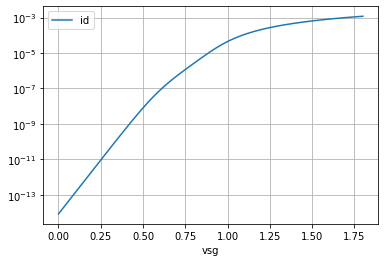

In [8]:
df.plot(x="vsg", y="id", logy=True, grid=True)
plt.show()

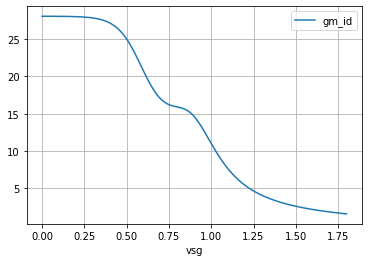

In [9]:
df.plot(x="vsg", y="gm_id", grid=True)
plt.show()

The above plot shows a problem with the PMOS model in the SKY130 PDK.